# Part 01 Clustering

comined          year  month  tmax  tmin         af   rain    sun        station
12     1942.0    1.0   5.8   2.1   3.460052  114.0   58.0  aberporthdata
13     1942.0    2.0   4.2  -0.6   3.460052   13.8   80.3  aberporthdata
14     1942.0    3.0   9.7   3.7   3.460052   58.0  117.9  aberporthdata
15     1942.0    4.0  13.1   5.3   3.460052   42.5  200.1  aberporthdata
16     1942.0    5.0  14.0   6.9   3.460052  101.1  215.1  aberporthdata
...       ...    ...   ...   ...        ...    ...    ...            ...
39527  2024.0   11.0  11.7   5.1   7.000000   88.6   48.8  yeoviltondata
39528  2024.0   12.0  10.5   5.0   1.000000   29.6   27.9  yeoviltondata
39529  2025.0    1.0   8.0   0.8  11.000000  139.0   57.1  yeoviltondata
39530  2025.0    2.0   8.9   2.8   5.000000   51.2   55.8  yeoviltondata
39531  2025.0    3.0  13.0   2.3  12.000000    6.4  166.4  yeoviltondata

[38940 rows x 8 columns]
shape (38940, 8)


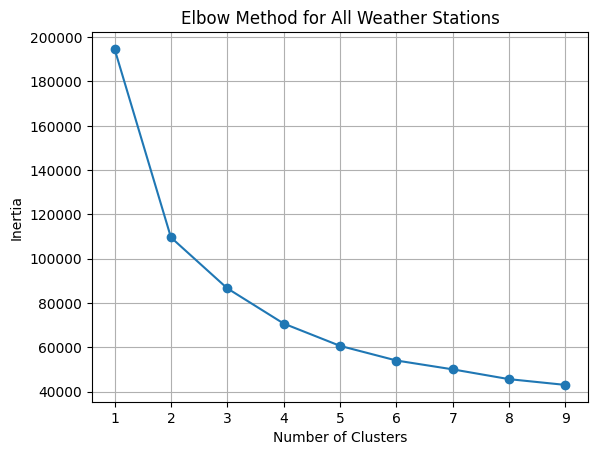

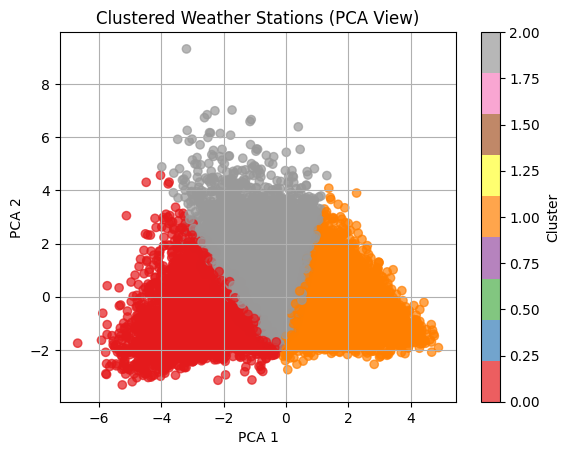

In [1]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Directory where your weather station text files are stored
folder_path = "weather_data_files"  # Replace with your actual path
columns = ['year', 'month', 'tmax', 'tmin', 'af', 'rain', 'sun']

def process_file(file_path):
    cleaned_data = []
    data_started = False
    with open(file_path, "r") as file:
        for line in file:
            line = re.sub(r'#.*', '', line)  # remove Provisional & sunshine markers
            line = re.sub(r'\s+', ' ', line.strip())  # normalize spaces

            if not line:
                continue

            # Skip metadata until we find a valid data line
            if not data_started:
                if re.match(r'^\d{4}\s', line):
                    data_started = True
                else:
                    continue

            parts = line.split()
            if len(parts) < 7:
                continue

            row = []
            for val in parts[:7]:
                val = val.replace('*', '')
                if val == '---':
                    row.append(np.nan)
                else:
                    try:
                        row.append(float(val))
                    except ValueError:
                        row.append(np.nan)
            cleaned_data.append(row)

    return pd.DataFrame(cleaned_data, columns=columns)

# Process all .txt files in the folder
all_dataframes = []

for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        df = process_file(file_path)
        if not df.empty:
            df['station'] = filename.replace('.txt', '')  # optional: add station name
            all_dataframes.append(df)

# Combine all stations' data
combined_df = pd.concat(all_dataframes, ignore_index=True)

# Drop rows with too many NaNs
combined_df_cleaned = combined_df.dropna(thresh=5)

# Fill remaining NaNs
combined_df_filled = combined_df_cleaned.fillna(combined_df_cleaned.mean(numeric_only=True))
print("comined",combined_df_filled)
print('shape',combined_df_filled.shape)
# Standardize features
features = ['tmax', 'tmin', 'af', 'rain', 'sun']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_df_filled[features])

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
combined_df_filled['cluster'] = kmeans.fit_predict(X_scaled)

# Elbow plot
inertia = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for All Weather Stations')
plt.grid(True)
plt.show()

# PCA Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=combined_df_filled['cluster'], cmap='Set1', alpha=0.7)
plt.title("Clustered Weather Stations (PCA View)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


# Part 02 Classification


Distribution of stations by region:
region
Central      9
Northern     4
Southern    24
dtype: int64
Test stations (excluded from training): ['valleydata', 'waddingtondata', 'whitbydata', 'wickairportdata', 'yeoviltondata']
Selected features:
['tmax_mean', 'tmax_std', 'tmax_max', 'tmax_<lambda_1>', 'tmin_mean', 'tmin_std', 'tmin_max', 'tmin_<lambda_0>', 'tmin_<lambda_1>', 'af_std', 'rain_mean', 'sun_min', 'sun_max', 'winter_tmin', 'summer_tmax', 'summer_tmin']


C:\Users\Zubair\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.7190

Random Forest Classification Report:
              precision    recall  f1-score   support

     Central       0.00      0.00      0.00         1
    Northern       1.00      1.00      1.00         1
    Southern       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.58      0.67      0.62         5
weighted avg       0.65      0.80      0.71         5

Random Forest Test Accuracy: 0.8000

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

     Central       0.00      0.00      0.00         1
    Northern       1.00      1.00      1.00         1
    Southern       0.75      1.00      0.86         3

    accuracy                           0.80         5
   macro avg       0.58      0.67      0.62         5
weighted avg       0.65      0.80   

C:\Users\Zubair\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Zubair\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Zubair\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

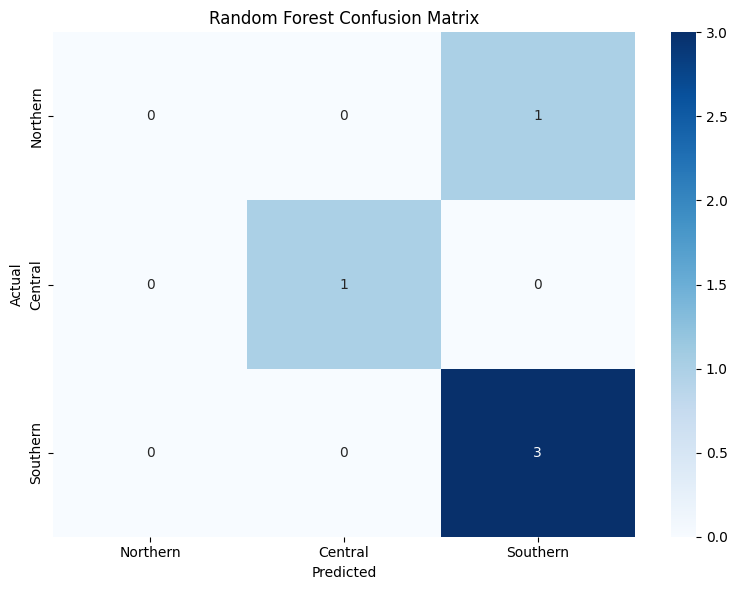

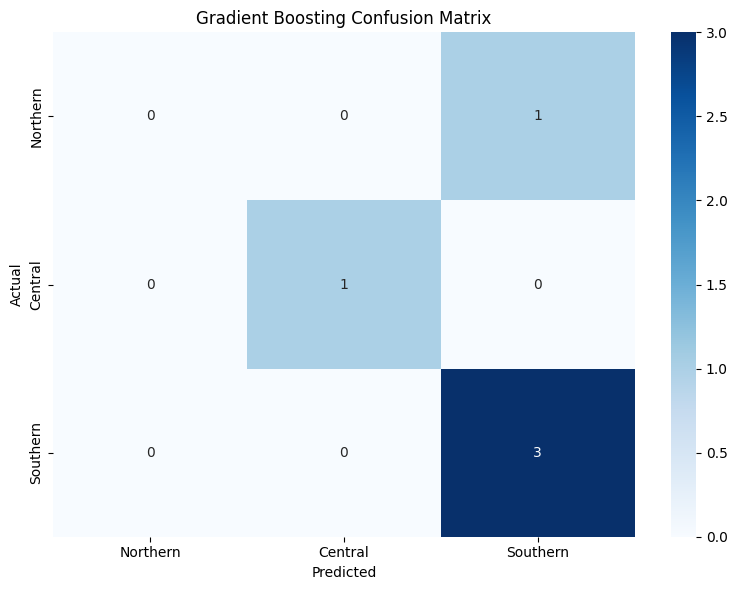

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


latitudes_data = {
    'aberporth': 52.139,
    'armagh': 54.352,
    'ballypatrick': 55.181,
    'bradford': 53.814,
    'braemardata': 57.006,
    'cambornedata': 50.218,
    'cambridgedata': 52.245,
    'cardiffdata': 51.487,
    'chivenordata': 51.089,
    'cwmystwythdata': 52.358,
    'dunstaffnagedata': 56.451,
    'durhamdata': 54.767,
    'eastbournedata': 50.762,
    'eskdalemuirdata': 55.311,
    'heathrowdata': 51.479,
    'hurndata': 50.779,
    'lerwickdata': 60.139,
    'leucharsdata': 56.377,
    'lowestoftdata': 52.483,
    'manstondata': 51.346,
    'newtonriggdata': 54.670,
    'oxforddata': 51.761,
    'paisleydata': 55.845,
    'ringwaydata': 53.356,
    'rossonwyedata': 51.910,
    'shawburydata': 52.794,
    'sheffielddata': 53.381,
    'southamptondata': 50.910,
    'stornowaydata': 58.214,
    'suttonboningtondata': 52.833,
    'tireedata': 56.497,
    'valleydata': 53.252,
    'waddingtondata': 53.175,
    'whitbydata': 54.481,
    'wickairportdata': 58.454,
    'yeoviltondata': 51.006,
    'nairndata': 57.593
}

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel



# Create station-level aggregated features
station_features = combined_df_filled.groupby('station')[['tmax', 'tmin', 'af', 'rain', 'sun']].agg([
    'mean', 'std', 'min', 'max', 
    lambda x: np.percentile(x, 25),  # 25th percentile
    lambda x: np.percentile(x, 75)   # 75th percentile
])

# Flatten the column structure
station_features.columns = ['_'.join(col).strip() for col in station_features.columns.values]

monthly_grouped = combined_df_filled.groupby(['station', 'month'])[['tmax', 'tmin', 'rain']].mean().reset_index()

# Extract seasonal features
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]

# Winter averages
winter_data = monthly_grouped[monthly_grouped['month'].isin(winter_months)]
winter_aggs = winter_data.groupby('station')[['tmax', 'tmin', 'rain']].mean()
winter_aggs = winter_aggs.rename(columns={'tmax': 'winter_tmax', 'tmin': 'winter_tmin', 'rain': 'winter_rain'})

# Summer averages
summer_data = monthly_grouped[monthly_grouped['month'].isin(summer_months)]
summer_aggs = summer_data.groupby('station')[['tmax', 'tmin', 'rain']].mean()
summer_aggs = summer_aggs.rename(columns={'tmax': 'summer_tmax', 'tmin': 'summer_tmin', 'rain': 'summer_rain'})

# Add seasonal difference features
station_features = station_features.join(winter_aggs).join(summer_aggs)
station_features['temp_seasonal_diff'] = station_features['summer_tmax'] - station_features['winter_tmax']
station_features['rain_seasonal_diff'] = station_features['summer_rain'] - station_features['winter_rain']

# Add latitude for creating labels
station_features['latitude'] = station_features.index.map(latitudes_data)

# Define the thirds of the UK
min_lat = 49.9
max_lat = 60.9
lat_range = max_lat - min_lat
third_size = lat_range / 3

# Create region labels
def assign_region(lat):
    if lat >= (min_lat + 2*third_size):
        return 'Northern'
    elif lat >= (min_lat + third_size):
        return 'Central'
    else:
        return 'Southern'

station_features['region'] = station_features['latitude'].apply(assign_region)

# Check the distribution
print("Distribution of stations by region:")
print(station_features.groupby('region').size())

# Exclude 5 last stations alphabetically
all_stations = sorted(station_features.index)
test_stations = all_stations[-5:]  # Last 5 alphabetically
print("Test stations (excluded from training):", test_stations)

# Split into training and test sets
train_df = station_features[~station_features.index.isin(test_stations)]
test_df = station_features[station_features.index.isin(test_stations)]

# Remove latitude from features (we don't want to use it for prediction)
X_train = train_df.drop(['latitude', 'region'], axis=1)
X_test = test_df.drop(['latitude', 'region'], axis=1)
y_train = train_df['region']
y_test = test_df['region']

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
base_clf.fit(X_train_scaled, y_train)

# Select important features
selector = SelectFromModel(base_clf, threshold='mean')
selector.fit(X_train_scaled, y_train)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

selected_feature_indices = selector.get_support(indices=True)
selected_features = X_train.columns[selected_feature_indices]
print("Selected features:")
print(selected_features.tolist())

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_selected, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Best model
best_rf = grid_search.best_estimator_

# Train also a GradientBoosting classifier
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_selected, y_train)

# Predictions
rf_pred = best_rf.predict(X_test_selected)
gb_pred = gb.predict(X_test_selected)

# Evaluation
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, rf_pred):.4f}")

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, gb_pred))
print(f"Gradient Boosting Test Accuracy: {accuracy_score(y_test, gb_pred):.4f}")

# Detailed analysis of test stations
test_results = pd.DataFrame({
    'Station': test_stations,
    'Latitude': [latitudes_data[station] for station in test_stations],
    'Actual Region': y_test.values,
    'RF Prediction': rf_pred,
    'GB Prediction': gb_pred
})
print("\nTest Station Predictions:")
print(test_results)


from sklearn.metrics import confusion_matrix
import seaborn as sns


plt.figure(figsize=(8, 6))
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Northern', 'Central', 'Southern'],
            yticklabels=['Northern', 'Central', 'Southern'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

# For Gradient Boosting
plt.figure(figsize=(8, 6))
cm_gb = confusion_matrix(y_test, gb_pred)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Northern', 'Central', 'Southern'],
            yticklabels=['Northern', 'Central', 'Southern'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boosting Confusion Matrix')
plt.tight_layout()
plt.show()